# DonorsChoose : Application Screening

## Description
<p> Source : https://www.kaggle.com/c/donorschoose-application-screening </p>
<p> Download train.zip and resources.zip from Kaggle.</p> 

### Problem statement :
<p> Predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved or not </p>

## Performance Metric

Source: https://www.kaggle.com/c/donorschoose-application-screening/overview/evaluation

Metric(s):

    Area Under Curve (AOC)
    Confusion Matrix


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, confusion_matrix

from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
import string
import re
import os
import pickle
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [5]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

catogories = list(project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_catogories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [7]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:29<00:00, 1215.18it/s]


In [17]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [18]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
preprocessed_titles[5438]

100%|██████████| 109248/109248 [00:04<00:00, 25480.32it/s]


'mac imize steam'

## 1.5 Preparing data for models

In [19]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [20]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

<h1>2. Decision Tree </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [21]:
#importing required libraries
import graphviz
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from prettytable import PrettyTable

#creating input and output parts
X = project_data[:].drop('project_is_approved', axis = 1)
Y = project_data[:]['project_is_approved']

#replacing essay and title column with preprocessed texts as it is needed in bow, tfidf,.. encoding
X['essay'] = preprocessed_essays[:]
X['project_title'] = preprocessed_titles[:]

#splitting the data into train/test
X_tr, X_test, Y_tr, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)

print("Shape of train and test data is : ",X_tr.shape, X_test.shape)

Shape of train and test data is :  (87398, 19) (21850, 19)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [22]:
#Encoding project_categories for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
categories_tr = vectorizer.fit_transform(X_tr['clean_categories'].values)
categories_test = vectorizer.transform(X_test['clean_categories'].values)

print("Shape of matrix after one hot encoding ",categories_tr.shape)
print("Shape of matrix after one hot encoding ",categories_test.shape)

Shape of matrix after one hot encoding  (87398, 9)
Shape of matrix after one hot encoding  (21850, 9)


In [23]:
#Encoding project_subcategories for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
subcategories_tr = vectorizer.fit_transform(X_tr['clean_subcategories'].values)
subcategories_test = vectorizer.transform(X_test['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ",subcategories_tr.shape)
print("Shape of matrix after one hot encoding ",subcategories_test.shape)

Shape of matrix after one hot encoding  (87398, 30)
Shape of matrix after one hot encoding  (21850, 30)


In [24]:
#Encoding school_state for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
school_state_tr = vectorizer.fit_transform(X_tr['school_state'].values)
school_state_test = vectorizer.transform(X_test['school_state'].values)

print("Shape of matrix after one hot encoding ",school_state_tr.shape)
print("Shape of matrix after one hot encoding ",school_state_test.shape)

Shape of matrix after one hot encoding  (87398, 51)
Shape of matrix after one hot encoding  (21850, 51)


In [25]:
#Encoding teacher_prefix for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
teacher_prefix_tr = vectorizer.fit_transform(map(str,X_tr['teacher_prefix'].values))
teacher_prefix_test = vectorizer.transform(map(str,X_test['school_state'].values))

print("Shape of matrix after one hot encoding ",teacher_prefix_tr.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_test.shape)

Shape of matrix after one hot encoding  (87398, 6)
Shape of matrix after one hot encoding  (21850, 6)


In [26]:
#Encoding project_grade_category for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
project_grade_category_tr = vectorizer.fit_transform(X_tr['project_grade_category'].values)
project_grade_category_test = vectorizer.transform(X_test['project_grade_category'].values)

print("Shape of matrix after one hot encoding ",project_grade_category_tr.shape)
print("Shape of matrix after one hot encoding ",project_grade_category_test.shape)

Shape of matrix after one hot encoding  (87398, 3)
Shape of matrix after one hot encoding  (21850, 3)


### 2.2.2 Encoding Numerical Features

In [27]:
#Standarizing for all sets, try printing their shape to test if code is correct or not
scalar = StandardScaler()
price_tr = scalar.fit_transform(X_tr['price'].values.reshape(-1, 1))
price_test = scalar.transform(X_test['price'].values.reshape(-1, 1))

In [28]:
#Standarizing for all sets, try printing their shape to test if code is correct or not
scalar = StandardScaler()
tnopp_tr = scalar.fit_transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
tnopp_test = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### 2.3.1 Encoding using bow

In [29]:
#Encoding essay for each data set using bow
vectorizer = CountVectorizer(min_df=10)
e_bow_tr = vectorizer.fit_transform(X_tr['essay'])
e_bow_test = vectorizer.transform(X_test['essay'])

print("Shape of matrix after bow encoding ",e_bow_tr.shape)
print("Shape of matrix after bow encoding ",e_bow_test.shape)

Shape of matrix after bow encoding  (87398, 15256)
Shape of matrix after bow encoding  (21850, 15256)


In [30]:
#Encoding title for each data set using bow
vectorizer = CountVectorizer(min_df=10)
t_bow_tr = vectorizer.fit_transform(X_tr['project_title'])
t_bow_test = vectorizer.transform(X_test['project_title'])

print("Shape of matrix after bow encoding ",t_bow_tr.shape)
print("Shape of matrix after bow encoding ",t_bow_test.shape)

Shape of matrix after bow encoding  (87398, 2926)
Shape of matrix after bow encoding  (21850, 2926)


### 2.3.2 Encoding using tfidf

In [31]:
#Encoding essay for each data set using tfidf
vectorizer = TfidfVectorizer(min_df=10)
e_tfidf_tr = vectorizer.fit_transform(X_tr['essay'])
e_tfidf_test = vectorizer.transform(X_test['essay'])

print("Shape of matrix after tfidf encoding ",e_tfidf_tr.shape)
print("Shape of matrix after tfidf encoding ",e_tfidf_test.shape)

Shape of matrix after tfidf encoding  (87398, 15256)
Shape of matrix after tfidf encoding  (21850, 15256)


In [32]:
#Encoding title for each data set using tfidf
vectorizer = TfidfVectorizer(min_df=10)
t_tfidf_tr = vectorizer.fit_transform(X_tr['project_title'])
t_tfidf_test = vectorizer.transform(X_test['project_title'])

print("Shape of matrix after tfidf encoding ",t_tfidf_tr.shape)
print("Shape of matrix after tfidf encoding ",t_tfidf_test.shape)

Shape of matrix after tfidf encoding  (87398, 2926)
Shape of matrix after tfidf encoding  (21850, 2926)


### 2.3.3 Encoding using avg_w2v

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [33]:
# average Word2Vec for essay
# compute average word2vec for training set.
e_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    e_w2v_tr.append(vector)


# compute average word2vec for test set.
e_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    e_w2v_test.append(vector)

print(len(e_w2v_tr))
print(len(e_w2v_test))

100%|██████████| 21850/21850 [00:19<00:00, 1100.40it/s]

87398
21850


In [34]:
# average Word2Vec for title
# compute average word2vec for training set.
t_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    t_w2v_tr.append(vector)


# compute average word2vec for test set.
t_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    t_w2v_test.append(vector)

print(len(t_w2v_tr))
print(len(t_w2v_test))

100%|██████████| 21850/21850 [00:00<00:00, 22519.03it/s]

87398
21850


### 2.3.4 Encoding using weigthed_w2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [36]:
# weighted Word2Vec for essay
# compute weighted word2vec for training set.
e_ww2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    e_ww2v_tr.append(vector)

    
# average Word2Vec
# compute average word2vec for test set.
e_ww2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    e_ww2v_test.append(vector)

print(len(e_ww2v_tr))
print(len(e_ww2v_test))

100%|██████████| 21850/21850 [02:04<00:00, 174.92it/s]

87398
21850


In [0]:
 S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [38]:
# weighted Word2Vec for title
# compute weighted word2vec for training set.
t_ww2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    t_ww2v_tr.append(vector)

    
# average Word2Vec
# compute average word2vec for test set.
t_ww2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    t_ww2v_test.append(vector)

print(len(t_ww2v_tr))
print(len(t_ww2v_test))

100%|██████████| 21850/21850 [00:02<00:00, 10114.35it/s]

87398
21850


### 2.3.5 Writing functions for specified task 

In [0]:
def cross_val(max_depth, min_samples_split):
    parameters = {'max_depth' : max_depth, 'min_samples_split' : min_samples_split}
    classifier = DecisionTreeClassifier()
    model = GridSearchCV(classifier, param_grid = parameters, scoring = 'roc_auc')
    model.fit(Xtr, Y_tr)
    return model

In [0]:
#printing auc values
def print_auc_values(model):
    results = pd.DataFrame(model.cv_results_)          #storing results of gridseachcv in a dataframe to access its elements
    params = results['params']                         #storing combination of parameters used by model in params
    auc_tr_array = results['mean_train_score']         #storing scores on train data of model
    auc_cv_array = results['mean_test_score']          #storing scores on cv data of model
    for i in range(len(params)):
        print("For max_depth = ",params[i]['max_depth'],"and min_samples_split = ",params[i]['min_samples_split'],"AUC of Train data is",auc_tr_array[i],"and AUC of CV data is", auc_cv_array[i])

In [0]:
#plotting auc values
def plotting_auc_values(model, max_depth, min_samples_split):
    plt.figure(figsize=(20,4))

    plt.subplot(1, 2, 1)
    scores_tr = model.cv_results_['mean_train_score'].reshape(len(max_depth),len(min_samples_split))
    sns.heatmap(scores_tr, annot=True, xticklabels=min_samples_split, yticklabels=max_depth)
    plt.xlabel('min_samples_split')
    plt.ylabel('max_depth')
    plt.title('Heatmap of train data')

    plt.subplot(1, 2, 2)
    scores_test = model.cv_results_['mean_test_score'].reshape(len(max_depth),len(min_samples_split))
    sns.heatmap(scores_test, annot=True, xticklabels=min_samples_split, yticklabels=max_depth)
    plt.xlabel('min_samples_split')
    plt.ylabel('max_depth')
    plt.title('Heatmap of test data')
    plt.show()

In [0]:
#plotting roc curve : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test):
    fpr_tr, tpr_tr, threshold_tr = roc_curve(Y_tr,  pred_tr)
    plt.plot(fpr_tr, tpr_tr, color = 'Red', label="Train data, auc="+str(auc_tr))
    fpr_test, tpr_test, threshold_test = roc_curve(Y_test,  pred_test)
    plt.plot(fpr_test ,tpr_test ,color = 'Blue', label="Test data , auc="+str(auc_test))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of Train and Test data for best parameter')
    plt.show()
    return fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test

In [0]:
# Function for predict, with defined thresould that will give the least fpr
def predict(proba, fpr, tpr, threshould):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
#plotting confusion matrix : http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
def plot_cm(pred_tr, pred_test):
    plt.figure(figsize=(15,4))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(Y_tr, pred_tr)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix of Train Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
            
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(Y_test, pred_test)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix of Train Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [0]:
#function for getting false positive points from dataset
def get_fp_data(pred, Y_test):
    ix = []          #list for storing indices of false positive points
    fp = 0
    actual = list(Y_test)

    for i in range(len(pred)):
        if pred[i]==1 and actual[i]!=pred[i]:         #calculating false positive points
            fp += 1
            ix.append(i)


    #Using the original test data set which was used before one hot encoding and text encoding(bow, tfidf, etc)
    X_fp = X_test.reset_index(drop = True).iloc[ix, :]      #resetting indices and selecting rows of above indices using iloc
    return X_fp

In [0]:
#generating word cloud : https://www.geeksforgeeks.org/generating-word-cloud-python/
def plot_word_cloud(X_fp):
    comment_words = ' '
    for essay in X_fp['essay']:                #loop for combining words from each essay
        tokens = essay.split()                 #split the words 

        for words in tokens: 
            comment_words = comment_words + words + ' '       #combine words from a single essay

    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('Word Cloud of words from false positive points')
    plt.show()

In [0]:
#plotting box_plot with the price of false positive data points
def box_plot(X_fp): 
    sns.boxplot(data=list(X_fp['price']))
    plt.title("Boxplot of price of false positive data points")
    plt.show()

In [0]:
#plotting pdf of teacher_number_of_previously_posted_projects of false positive data points
def plot_pdf(X_fp):
    counts, bin_edges = np.histogram(X_fp['teacher_number_of_previously_posted_projects'], bins=10, density = True)
    pdf = counts/(sum(counts))
    plt.plot(bin_edges[1:], pdf)
    plt.title("PDF of teacher_number_of_previously_posted_projects of false positive points")
    plt.show()

In [33]:
#function for getting feature names of bow encoding
def bow_feature_names():
    #creating all the vectorizer which were used for encoding
    vectorizer = CountVectorizer(lowercase=False, binary=True)
    vectorizer.fit(X_tr['school_state'].values)
    school_state_feature_names = vectorizer.get_feature_names()
 
    vectorizer.fit(X_tr['clean_categories'].values)
    categories_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(X_tr['clean_subcategories'].values)
    subcategories_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(map(str,X_tr['teacher_prefix'].values))
    teacher_prefix_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(X_tr['project_grade_category'].values)
    project_grade_category_feature_names = vectorizer.get_feature_names()


    #vectorzier for essay and test
    vectorizer = CountVectorizer(min_df=10)
    vectorizer.fit(X_tr['essay'])
    e_bow_feature_names = vectorizer.get_feature_names()

    vectorizer.fit_transform(X_tr['project_title'])
    t_bow_feature_names = vectorizer.get_feature_names()

    #concatinating all feature names
    complete_feature_names = categories_feature_names + subcategories_feature_names + school_state_feature_names + teacher_prefix_feature_names + project_grade_category_feature_names + e_bow_feature_names + t_bow_feature_names

    #concatinating price and teacher_number_of_previously_posted_projects feature names
    complete_feature_names.append('price')
    complete_feature_names.append('teacher_number_of_previously_posted_projects')
    return complete_feature_names

In [34]:
#function for getting feature names of tfidf encoding
def tfidf_feature_names():
    #creating all the vectorizer which were used for encoding
    vectorizer = CountVectorizer(lowercase=False, binary=True)
    vectorizer.fit(X_tr['school_state'].values)
    school_state_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(X_tr['clean_categories'].values)
    categories_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(X_tr['clean_subcategories'].values)
    subcategories_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(map(str,X_tr['teacher_prefix'].values))
    teacher_prefix_feature_names = vectorizer.get_feature_names()

    vectorizer.fit(X_tr['project_grade_category'].values)
    project_grade_category_feature_names = vectorizer.get_feature_names()


    #vectorzier for essay and test
    vectorizer = TfidfVectorizer(min_df=10)
    vectorizer.fit(X_tr['essay'])
    e_bow_feature_names = vectorizer.get_feature_names()

    vectorizer.fit_transform(X_tr['project_title'])
    t_bow_feature_names = vectorizer.get_feature_names()

    #concatinating all feature names
    complete_feature_names = categories_feature_names + subcategories_feature_names + school_state_feature_names + teacher_prefix_feature_names + project_grade_category_feature_names + e_bow_feature_names + t_bow_feature_names

    #concatinating price and teacher_number_of_previously_posted_projects feature names
    complete_feature_names.append('price')
    complete_feature_names.append('teacher_number_of_previously_posted_projects')
    return complete_feature_names

<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Applying Decision Trees on BOW,<font color='red'> SET 1</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
For max_depth =  1 and min_samples_split =  5 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  10 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  100 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  5 and min_samples_split =  5 AUC of Train data is 0.6411635304166726 and AUC of CV data is 0.6308441087023964
For max_depth =  5 and min_samples_split =  10 AUC of Train data is 0.6411366700677875 and AUC of CV data is 0.6306655541654153
For max_depth =  5 and min_samples_split =  100 AUC of Train data is 0.6411315413933294 and AUC of CV data is 0.6306984053856741
For max_depth =  10 and min_samples_split =  5 AUC of Train data is 0.7017456081978325 and AUC of CV data is 0.6527984907456649
For max_depth =  10 and min_samples_split 

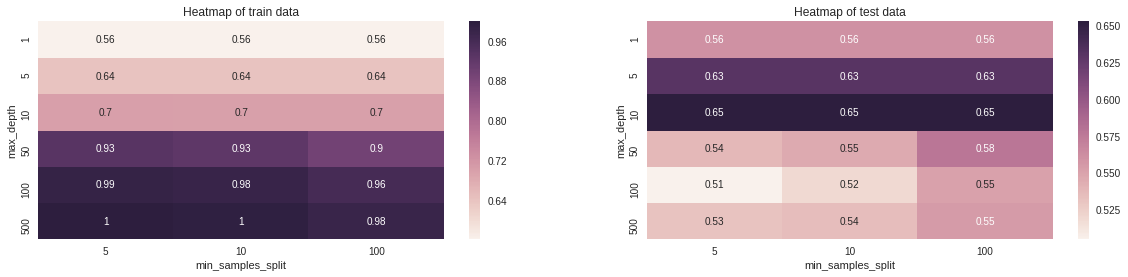

Values of best parameters are {'max_depth': 10, 'min_samples_split': 5} and auc value is 0.6527984907456649
For best parameters AUC of Train data is 0.698552913471707 and AUC of Test data is 0.6593742851833935


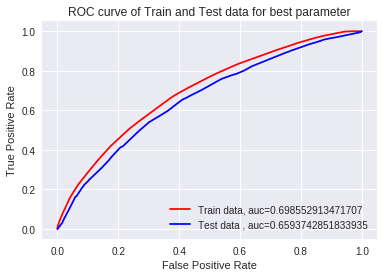

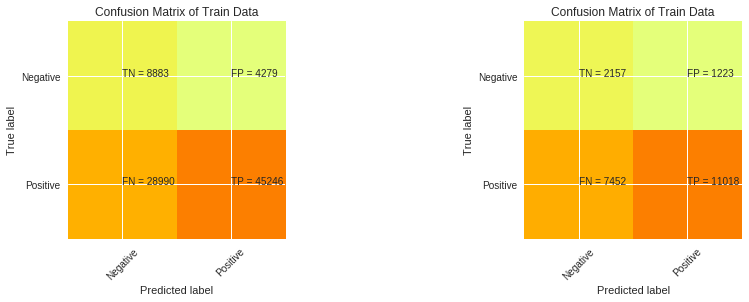

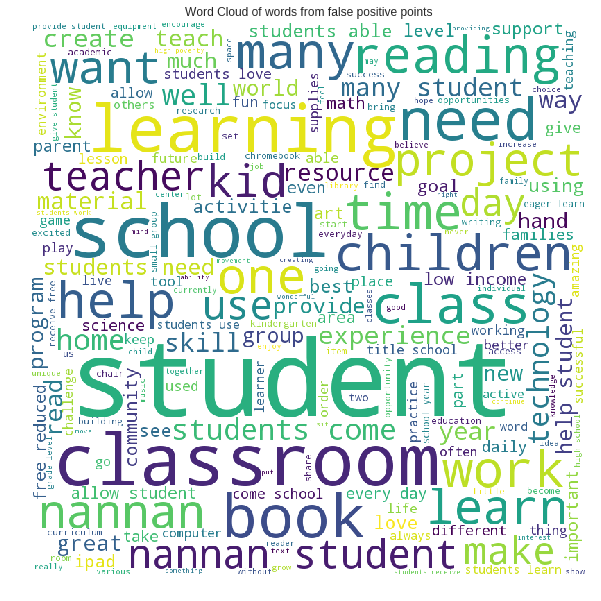

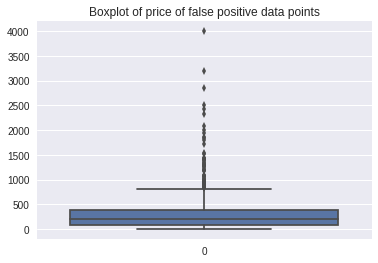

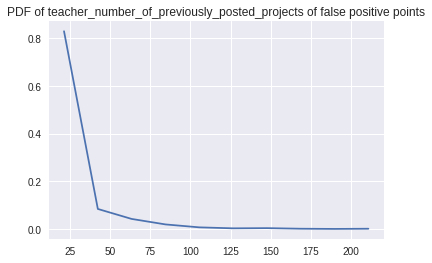

In [0]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_bow_tr, t_bow_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_bow_test, t_bow_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
max_depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100]
model = cross_val(max_depth, min_samples_split)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, max_depth, min_samples_split)

#Using model with best parameters
param_bow = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.predict_proba(Xtr)[:,1]
pred_test = model.predict_proba(Xtest)[:,1]
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred_tr = predict(pred_tr, fpr_tr, tpr_tr, threshold_tr)
pred_test = predict(pred_test, fpr_test, tpr_test, threshold_test)

#Plotting confusion matrix
plot_cm(pred_tr, pred_test)

#stroing auc values for Conclusion
auc_bow_tr = auc_tr
auc_bow_test = auc_test

#getting dataframe of false positive points
X_fp = get_fp_data(pred_test, Y_test)

#plotting word clound
plot_word_cloud(X_fp)

#plotting boxplot
box_plot(X_fp)

#plotting pdf
plot_pdf(X_fp)

#### 2.4.1.1 Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
Length of feature names 18283


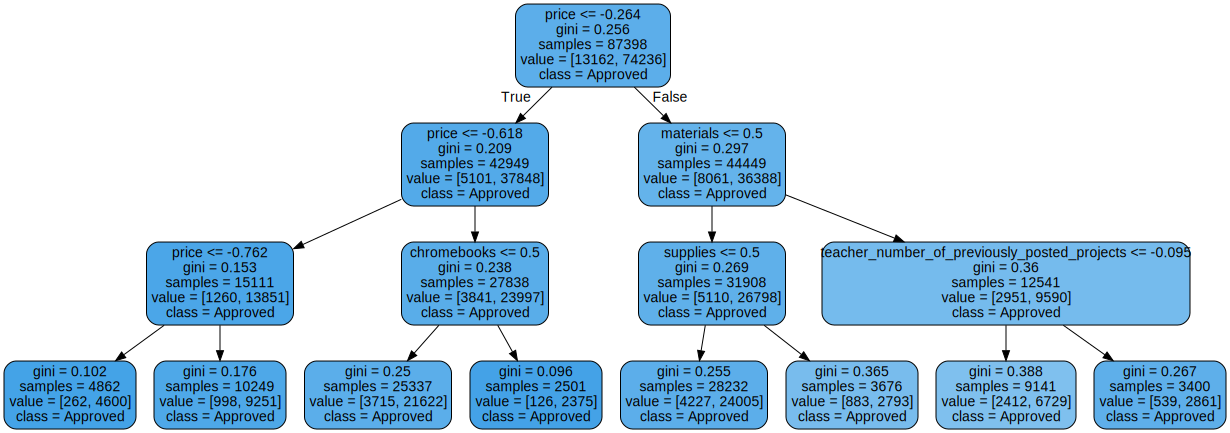

In [38]:
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_bow_tr, t_bow_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_bow_test, t_bow_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

feature_names = bow_feature_names()
print('Length of feature names',len(feature_names))
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xtr,Y_tr)
dot_data = export_graphviz(clf, out_file=None, feature_names = feature_names, class_names = ['Not Approved', 'Approved'], filled=True, rounded=True)  
graph = graphviz.Source(dot_data) 
graph

### 2.4.2 Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
For max_depth =  1 and min_samples_split =  5 AUC of Train data is 0.5499122088460496 and AUC of CV data is 0.5490343523196506
For max_depth =  1 and min_samples_split =  10 AUC of Train data is 0.5499122088460496 and AUC of CV data is 0.5490343523196506
For max_depth =  1 and min_samples_split =  100 AUC of Train data is 0.5499122088460496 and AUC of CV data is 0.5490343523196506
For max_depth =  5 and min_samples_split =  5 AUC of Train data is 0.6357197322677587 and AUC of CV data is 0.6237450632512235
For max_depth =  5 and min_samples_split =  10 AUC of Train data is 0.6357130273545725 and AUC of CV data is 0.6237448391480162
For max_depth =  5 and min_samples_split =  100 AUC of Train data is 0.635668824913591 and AUC of CV data is 0.6237398878737244
For max_depth =  10 and min_samples_split =  5 AUC of Train data is 0.6952629655809068 and AUC of CV data is 0.6383977178178608
For max_depth =  10 and min_samples_spli

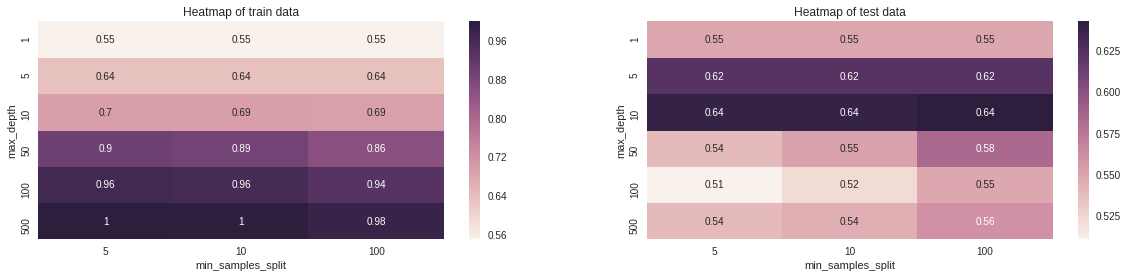

Values of best parameters are {'max_depth': 10, 'min_samples_split': 100} and auc value is 0.6424896227549033
For best parameters AUC of Train data is 0.6911112893561735 and AUC of Test data is 0.6546162496035471


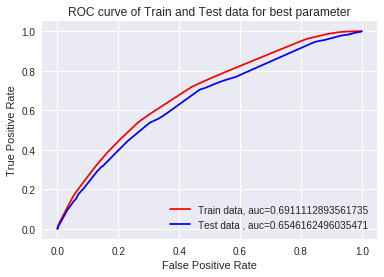

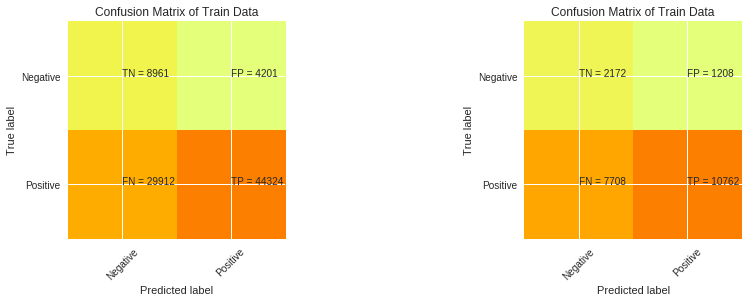

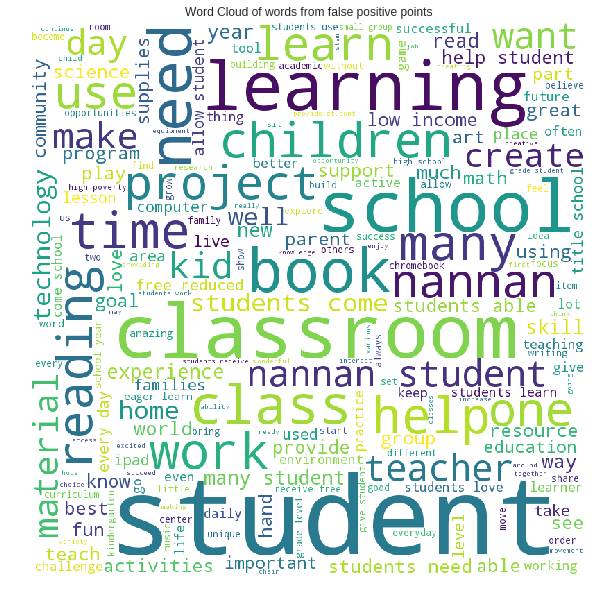

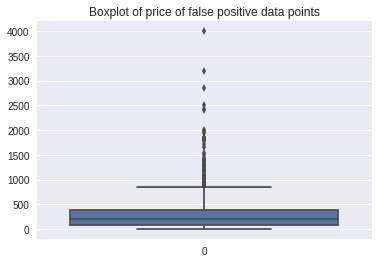

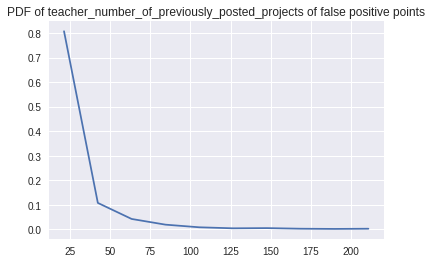

In [0]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_tfidf_tr, t_tfidf_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_tfidf_test, t_tfidf_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
max_depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100]
model = cross_val(max_depth, min_samples_split)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, max_depth, min_samples_split)

#Using model with best parameters
param_tfidf = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.predict_proba(Xtr)[:,1]
pred_test = model.predict_proba(Xtest)[:,1]
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred_tr = predict(pred_tr, fpr_tr, tpr_tr, threshold_tr)
pred_test = predict(pred_test, fpr_test, tpr_test, threshold_test)

#Plotting confusion matrix
plot_cm(pred_tr, pred_test)

#stroing auc_test value for Conclusion
auc_tfidf_tr = auc_tr
auc_tfidf_test = auc_test

#getting dataframe of false positive points
X_fp = get_fp_data(pred_test, Y_test)

#plotting word clound
plot_word_cloud(X_fp)

#plotting boxplot
box_plot(X_fp)

#plotting pdf
plot_pdf(X_fp)

#### 2.4.2.1 Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
Length of feature names 18283


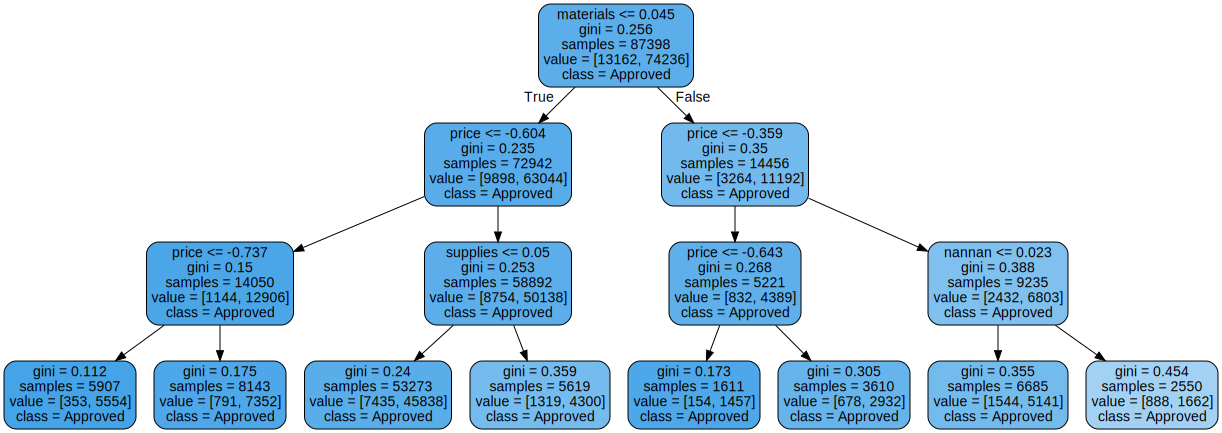

In [42]:
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_tfidf_tr, t_tfidf_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_tfidf_test, t_tfidf_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

feature_names = tfidf_feature_names()
print('Length of feature names',len(feature_names))
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xtr,Y_tr)
dot_data = export_graphviz(clf, out_file=None, feature_names = feature_names, class_names = ['Not Approved', 'Approved'], filled=True, rounded=True)  
graph = graphviz.Source(dot_data) 
graph

### 2.4.3 Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>



Shape of train and test data is :  (87398, 701) (21850, 701)
For max_depth =  1 and min_samples_split =  5 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  10 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  100 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  5 and min_samples_split =  5 AUC of Train data is 0.6522589756733425 and AUC of CV data is 0.6269564508931315
For max_depth =  5 and min_samples_split =  10 AUC of Train data is 0.6522388056506835 and AUC of CV data is 0.6268422314665077
For max_depth =  5 and min_samples_split =  100 AUC of Train data is 0.6522388056506835 and AUC of CV data is 0.626930196941175
For max_depth =  10 and min_samples_split =  5 AUC of Train data is 0.7466822635405416 and AUC of CV data is 0.6053285846891229
For max_depth =  10 and min_samples_split =  10

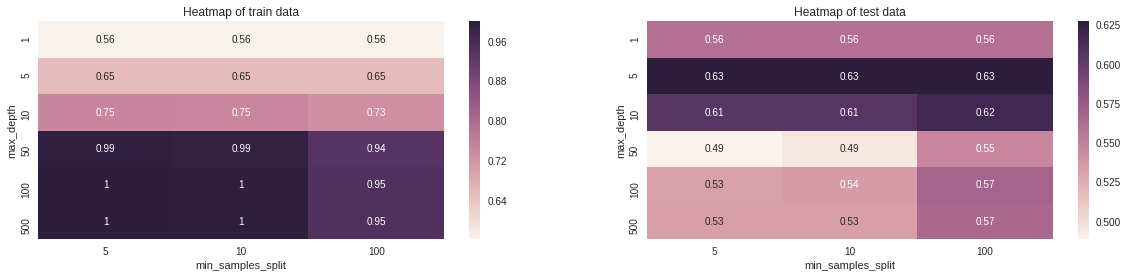

Values of best parameters are {'max_depth': 5, 'min_samples_split': 5} and auc value is 0.6269564508931315
For best parameters AUC of Train data is 0.6493173567316688 and AUC of Test data is 0.6395701008832491


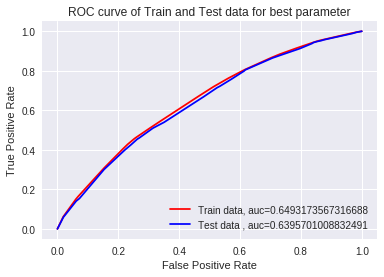

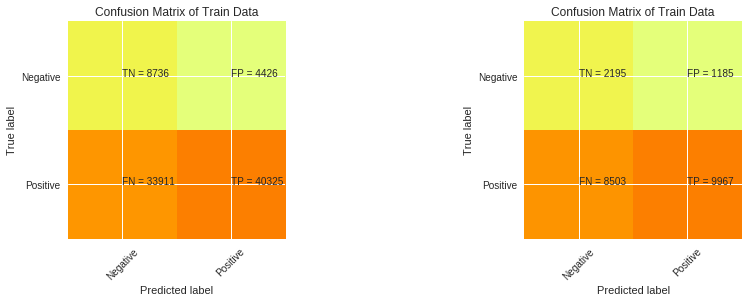

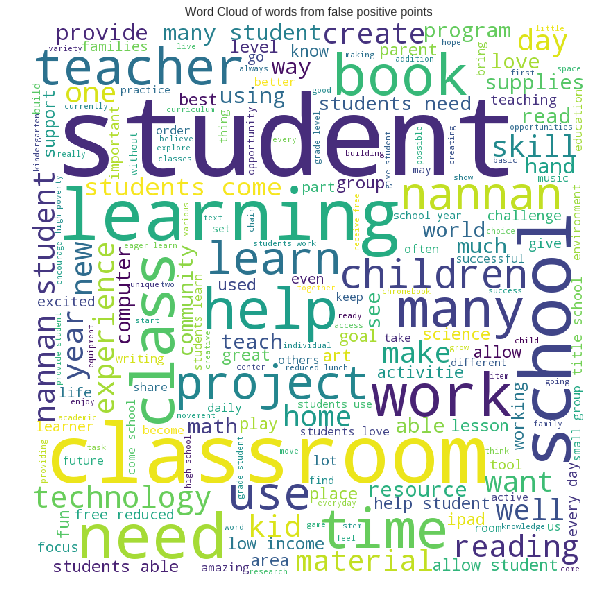

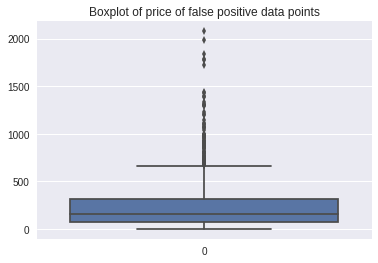

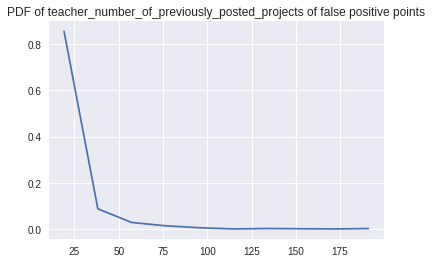

In [51]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_w2v_tr, t_w2v_tr, price_tr, tnopp_tr)).toarray()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_w2v_test, t_w2v_test, price_test, tnopp_test)).toarray()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
max_depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100]
model = cross_val(max_depth, min_samples_split)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, max_depth, min_samples_split)

#Using model with best parameters
param_w2v = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.predict_proba(Xtr)[:,1]
pred_test = model.predict_proba(Xtest)[:,1]
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred_tr = predict(pred_tr, fpr_tr, tpr_tr, threshold_tr)
pred_test = predict(pred_test, fpr_test, tpr_test, threshold_test)

#Plotting confusion matrix
plot_cm(pred_tr, pred_test)

#stroing auc values for Conclusion
auc_w2v_tr = auc_tr
auc_w2v_test = auc_test

#getting dataframe of false positive points
X_fp = get_fp_data(pred_test, Y_test)

#plotting word clound
plot_word_cloud(X_fp)

#plotting boxplot
box_plot(X_fp)

#plotting pdf
plot_pdf(X_fp)

### 2.4.4 Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

Shape of train and test data is :  (87398, 701) (21850, 701)
For max_depth =  1 and min_samples_split =  5 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  10 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  1 and min_samples_split =  100 AUC of Train data is 0.5612300231481985 and AUC of CV data is 0.560670849513938
For max_depth =  5 and min_samples_split =  5 AUC of Train data is 0.6591166316829976 and AUC of CV data is 0.6332790665537177
For max_depth =  5 and min_samples_split =  10 AUC of Train data is 0.6591031735011184 and AUC of CV data is 0.6332655961271509
For max_depth =  5 and min_samples_split =  100 AUC of Train data is 0.6591031735011184 and AUC of CV data is 0.6333525290464482
For max_depth =  10 and min_samples_split =  5 AUC of Train data is 0.7561503715978466 and AUC of CV data is 0.613959374317725
For max_depth =  10 and min_samples_split =  10

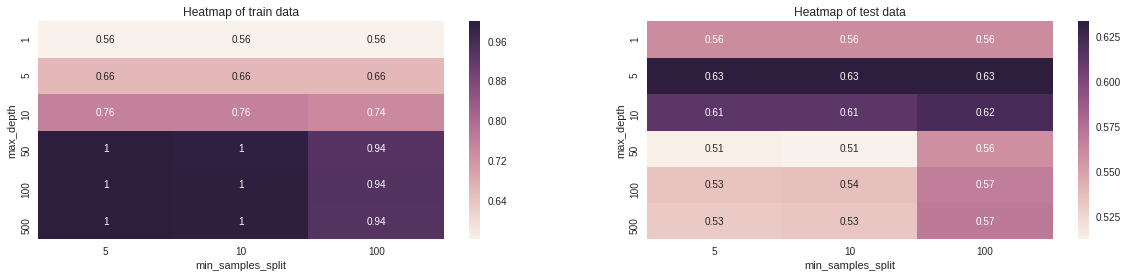

Values of best parameters are {'max_depth': 5, 'min_samples_split': 100} and auc value is 0.6333525290464482
For best parameters AUC of Train data is 0.6553546674708034 and AUC of Test data is 0.6369063858552011


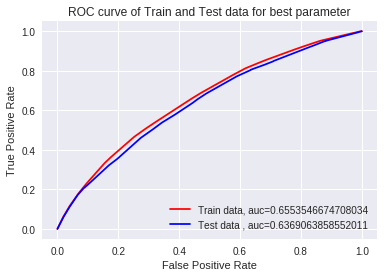

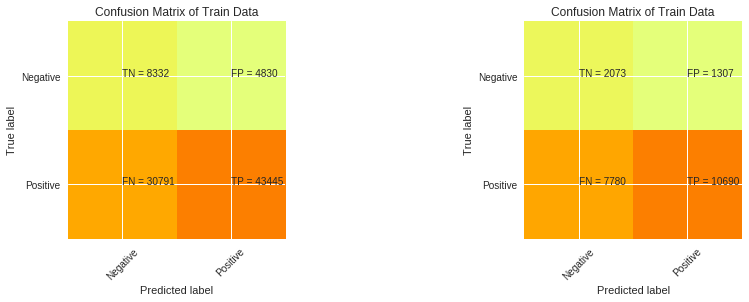

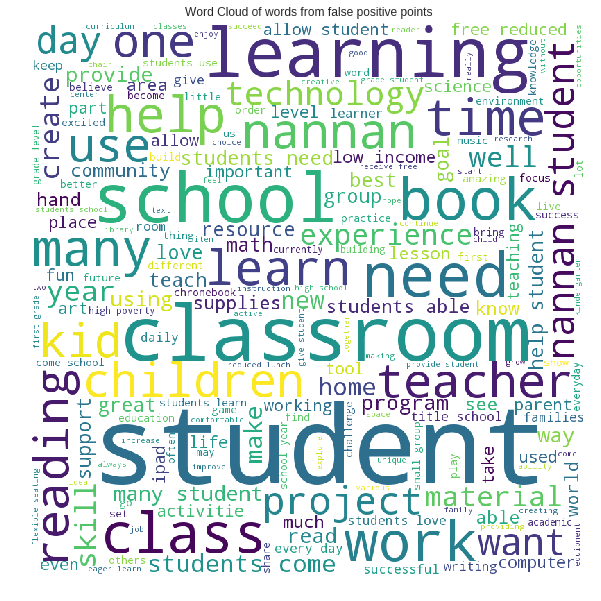

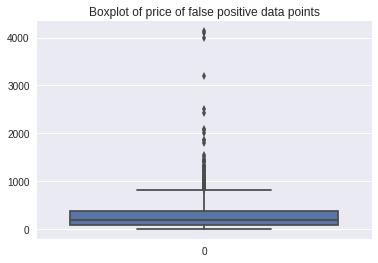

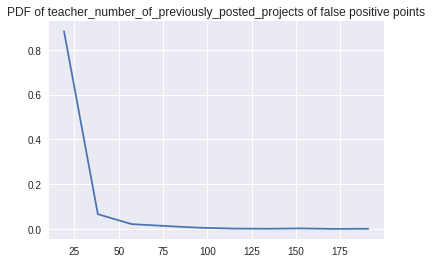

In [52]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_ww2v_tr, t_ww2v_tr, price_tr, tnopp_tr)).toarray()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_ww2v_test, t_ww2v_test, price_test, tnopp_test)).toarray()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
max_depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100]
model = cross_val(max_depth, min_samples_split)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, max_depth, min_samples_split)

#Using model with best parameters
param_ww2v = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.predict_proba(Xtr)[:,1]
pred_test = model.predict_proba(Xtest)[:,1]
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred_tr = predict(pred_tr, fpr_tr, tpr_tr, threshold_tr)
pred_test = predict(pred_test, fpr_test, tpr_test, threshold_test)

#Plotting confusion matrix
plot_cm(pred_tr, pred_test)

#stroing auc values for Conclusion
auc_ww2v_tr = auc_tr
auc_ww2v_test = auc_test

#getting dataframe of false positive points
X_fp = get_fp_data(pred_test, Y_test)

#plotting word clound
plot_word_cloud(X_fp)

#plotting boxplot
box_plot(X_fp)

#plotting pdf
plot_pdf(X_fp)

<h2>2.5 Getting top 5k features using `feature_importances_`</h2>

Select 5k best features from features of Set 2 usingfeature_importances_, discard all the other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3

In [53]:
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_tfidf_tr, t_tfidf_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_tfidf_test, t_tfidf_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500)    #parameters of best classifier for tfidf
clf.fit(Xtr,Y_tr)

indices = np.argsort(-clf.feature_importances_)        #taking indices of top features for slicing
Xtr_5k = Xtr[:,indices[:5000]]
Xtest_5k = Xtest[:,indices[:5000]]
print('Shape after selecting 5k best features',Xtr_5k.shape, Xtest_5k.shape)

Shape of train and test data is :  (87398, 18283) (21850, 18283)
Shape after selecting 5k best features (87398, 5000) (21850, 5000)


### 2.5.1 Training SVM on top 5k features.

For alpha =  0.0001 AUC of Train data is 0.7414664676232693 and AUC of CV data is 0.676335231423116
For alpha =  0.001 AUC of Train data is 0.717884496937614 and AUC of CV data is 0.6528662687530624
For alpha =  0.01 AUC of Train data is 0.7119148953424531 and AUC of CV data is 0.6652058520326928
For alpha =  0.1 AUC of Train data is 0.5733432967709032 and AUC of CV data is 0.5729816934611939
For alpha =  1 AUC of Train data is 0.6064562240590463 and AUC of CV data is 0.6063413009991017
For alpha =  10 AUC of Train data is 0.6064490745985719 and AUC of CV data is 0.6063299212147206
For alpha =  100 AUC of Train data is 0.6064490745985719 and AUC of CV data is 0.6063299212147206
For alpha =  1000 AUC of Train data is 0.6064490745985719 and AUC of CV data is 0.6063299212147206
For alpha =  10000 AUC of Train data is 0.6064490745985719 and AUC of CV data is 0.6063299212147206


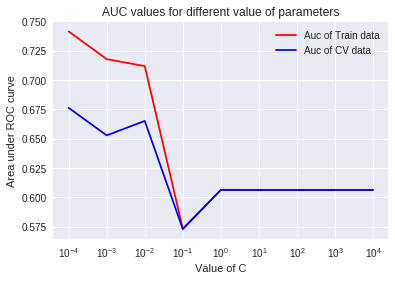

Values of best parameters are {'alpha': 0.0001} and auc value is 0.676335231423116
For best parameters AUC of Train data is 0.7288520903887601 and AUC of Test data is 0.6853693018904797


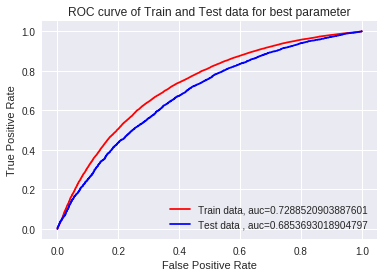

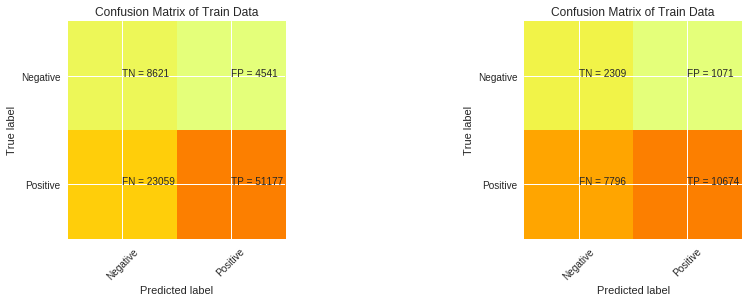

In [55]:
from sklearn.linear_model import SGDClassifier

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
parameters = {'alpha' : alpha}

classifier = SGDClassifier(loss = 'hinge')
model = GridSearchCV(classifier, param_grid = parameters, scoring ='roc_auc')
model.fit(Xtr_5k, Y_tr)

#printing auc values
results = pd.DataFrame(model.cv_results_)
params = results['params']
auc_tr_array = results['mean_train_score']
auc_cv_array = results['mean_test_score']
for i in range(len(params)):
    print("For alpha = ",params[i]['alpha'],"AUC of Train data is",auc_tr_array[i],"and AUC of CV data is", auc_cv_array[i])

#plotting auc values
plt.plot(alpha, auc_tr_array, '-k', color='red', label = 'Auc of Train data')
plt.plot(alpha, auc_cv_array, '-k', color='blue', label = 'Auc of CV data')
plt.xscale("log")
plt.xlabel('Value of C')
plt.ylabel('Area under ROC curve')
plt.title('AUC values for different value of parameters')
plt.legend()
plt.show()   
         
#Using model with best parameters
param_5k = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr_5k)
pred_test = model.decision_function(Xtest_5k)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr_tr, tpr_tr, threshold_tr, fpr_test, tpr_test, threshold_test = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred_tr = predict(pred_tr, fpr_tr, tpr_tr, threshold_tr)
pred_test = predict(pred_test, fpr_test, tpr_test, threshold_test)

#Plotting confusion matrix
plot_cm(pred_tr, pred_test)

#stroing auc values for Conclusion
auc_5k_tr = auc_tr
auc_5k_test = auc_test

<h1>3. Conclusion</h1>

In [59]:
# Please compare all your models using Prettytable library
t = PrettyTable()
t.field_names = ["Vectorizer", "Model", "Hyperparameter","AUC on Train data","AUC on Test data"]
t.add_row(["BOW", "Decision Tree", param_bow, auc_bow_tr, auc_bow_test])
t.add_row(["TFIDF", "Decision Tree", param_tfidf, auc_tfidf_tr, auc_tfidf_test])
t.add_row(["W2V", "Decision Tree", param_w2v, auc_w2v_tr, auc_w2v_test])
t.add_row(["TFIDFW2V", "Decision Tree", param_ww2v, auc_ww2v_tr, auc_ww2v_test])
t.add_row(["5k_features", "Linear SVM", param_5k, auc_5k_tr, auc_5k_test])
print(t)

+-------------+---------------+---------------------------------------------+--------------------+--------------------+
|  Vectorizer |     Model     |                Hyperparameter               | AUC on Train data  |  AUC on Test data  |
+-------------+---------------+---------------------------------------------+--------------------+--------------------+
|     BOW     | Decision Tree |  {'max_depth': 10, 'min_samples_split': 5}  | 0.698552913471707  | 0.6593742851833935 |
|    TFIDF    | Decision Tree | {'max_depth': 10, 'min_samples_split': 100} | 0.6911112893561735 | 0.6546162496035471 |
|     W2V     | Decision Tree |   {'max_depth': 5, 'min_samples_split': 5}  | 0.6493173567316688 | 0.6395701008832491 |
|   TFIDFW2V  | Decision Tree |  {'max_depth': 5, 'min_samples_split': 100} | 0.6553546674708034 | 0.6369063858552011 |
| 5k_features |   Linear SVM  |              {'alpha': 0.0001}              | 0.7288520903887601 | 0.6853693018904797 |
+-------------+---------------+---------